In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
filename = 'data_5kpa_cleaned_01052022.csv'
df = pd.read_csv(filename)
df.drop(['Unnamed: 0', 'WIDTH_sub', 'HEIGHT_sub', 'mem_layer'], axis=1, inplace=True)
df_var = df[['WIDTH_mem', 'THICKNESS_mem', 'WIDTH_device', 'HEIGHT_chamber', 'HEIGHT_device', 'Stalk_angle']]
df_perf = df[['strength', 'switching_ratio']]

In [3]:
df_var.head()

,WIDTH_mem,THICKNESS_mem,WIDTH_device,HEIGHT_chamber,HEIGHT_device,Stalk_angle
0,3.443420,2.022129,17.121868,9.886087,14.670482,-48.521273
1,2.255331,1.123090,19.712945,7.968753,13.878118,-28.887618
2,9.683886,2.879514,15.787672,6.783376,12.544746,29.972634
3,6.008156,1.296631,19.274046,3.803054,13.982056,-45.285397
4,7.404020,2.323556,15.113540,9.474165,14.553305,-45.516214


In [4]:
df_perf.head()

,strength,switching_ratio
0,30.276211,0.956090
1,40.221500,0.996982
2,26.674799,0.974735
3,39.913605,1.014244
4,23.948786,0.925598


### Neural network ML

In [5]:
train_X, test_X, train_y, test_y = train_test_split(df_var.values, df_perf.values, 
                                                    test_size=0.2, random_state=33)

In [6]:
X_train = torch.FloatTensor(train_X)
X_test = torch.FloatTensor(test_X)
y_train = torch.FloatTensor(train_y)
y_test = torch.FloatTensor(test_y)

In [7]:
class Model(nn.Module):
    def __init__(self, in_features=6, h1=8, h2=9, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [8]:
torch.manual_seed(11)
model = Model()

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [10]:
epochs = 1000
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%100 == 0:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 100  loss: 12.29694939
epoch: 200  loss: 3.83538580
epoch: 300  loss: 2.43247151
epoch: 400  loss: 2.26217103
epoch: 500  loss: 2.11885357
epoch: 600  loss: 1.97141516
epoch: 700  loss: 1.82005560
epoch: 800  loss: 1.66778839
epoch: 900  loss: 1.51914966
epoch: 1000  loss: 1.38278794


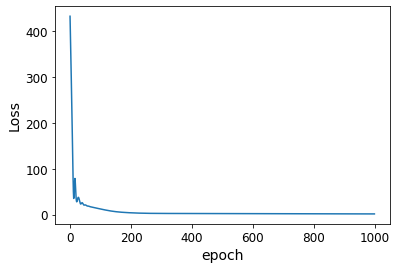

In [11]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [12]:
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

1.13089120


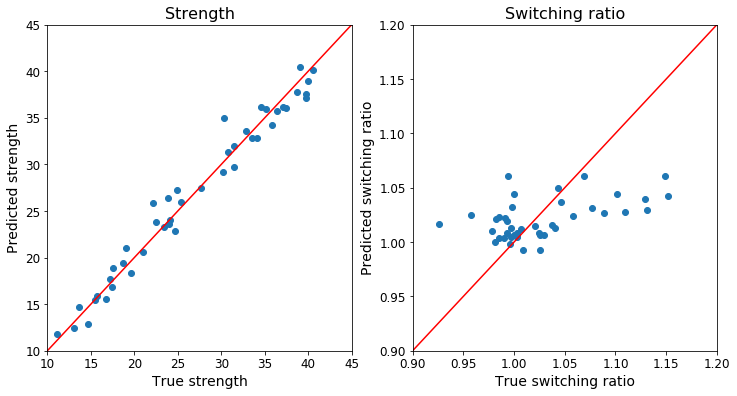

In [13]:
plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Strength", fontsize=16)
plt.plot([10, 45], [10, 45], c='red')
plt.scatter(y_test[:,0], y_val[:,0])
plt.xlim((10, 45))
plt.ylim((10, 45))
plt.xlabel('True strength', fontsize=14)
plt.ylabel('Predicted strength', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
plt.title("Switching ratio", fontsize=16)
plt.plot([0.9, 1.2], [0.9, 1.2], c='red')
plt.scatter(y_test[:,1], y_val[:,1])
plt.xlim((0.9, 1.2))
plt.ylim((0.9, 1.2))
plt.xlabel('True switching ratio', fontsize=14)
plt.ylabel('Predicted switching ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Test with examples

In [14]:
index_of_choice = 17
with torch.no_grad():
    y_pred = model(X_test[index_of_choice])
print(f'Predicted performances: {y_pred}')
print(f'Ground truth: {y_test[index_of_choice]}')

Predicted performances: tensor([34.2655,  1.0313])
Ground truth: tensor([35.8119,  1.0765])
